# BERT BASE MODEL DEVELOPMENT
Base model for binary classification against the NLTK corpus

### SETUP & LOAD DATA

In [ ]:
!pip install tensorflow-datasets --quiet
!pip install -U tensorflow-text --quiet
!pip install pydot --quiet
!pip install nltk --quiet
!pip install transformers --quiet
!pip install pyarrow -quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 42.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 31.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 43.7 MB/s eta 0:00:00

Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: -u


In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd

from tensorflow import keras
from tensorflow.keras.models import save_model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds
import tensorflow_text as tf_text

import sklearn as sk
import os
import nltk
from nltk.data import find

import matplotlib.pyplot as plt
import random
import re

nltk.download('gutenberg')
from nltk.corpus import gutenberg

nltk.download('punkt')
from nltk.tokenize import sent_tokenize

from google.colab import drive

import pyarrow as pya

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# Mount drive to retrieve data frame
drive.mount('/content/drive')

Mounted at /content/drive


# Load Corpus
Prepare and shuffle data groups

In [ ]:
# Retrieve parquet format into a dataframe
import pyarrow.parquet as pq

file = "/content/drive/My Drive/w266_Project/ProjectStore/nltk_corpus_df_chunks.parquet"

table = pya.parquet.read_table(file)
df = table.to_pandas()
df

,Author,Short Title,Title,Sentence Count,Sentence Groups,Group Counts,Train,Valid,Test
0,austen,emma,[ Emma by Jane Austen 1816 ],7751,"[VOLUME ICHAPTER IEmma Woodhouse , handsome , ...",1938,[Much beyond my hopes .Harriet is disgraced by...,"["" Oh yes !-- that is , no -- I do not know --...","["" Oh !dear , no ,"" said her companion .They w..."
1,austen,persuasion,[ Persuasion by Jane Austen 1818 ],3746,"[Chapter 1Sir Walter Elliot , of Kellynch Hall...",937,"[He got up and moved away ."" What a great trav...","[He was preparing only to bow and pass on , bu...",[Anne had always felt that she would pretend w...
2,austen,sense,[ Sense and Sensibility by Jane Austen 1811 ],4998,[CHAPTER 1The family of Dashwood had long been...,1250,"["" Oh , dear , that is a great pity !but such ...","["" Yes , you have certainly removed something ...","[At the end of another day or two , Marianne g..."
3,bryant,stories,[ Stories to Tell to Children by Sara Cone Bry...,2862,[TWO LITTLE RIDDLES IN RHYMEThere ' s a garden...,716,"["" Very good , very good ,"" trumpeted the Elep...",[The dark green Fir looks so majestic when lad...,"["" Begorra , now , I ' ll have yees Widout muc..."
4,burgess,busterbrown,[ The Adventures of Buster Bear by Thornton W ...,1053,[IBUSTER BEAR GOES FISHINGBuster Bear yawned a...,264,[Then he hurried down to the next little pool ...,"[When he came in sight of the little pool , wh...",[Because Old Mr . Toad insists that I must wri...
5,carroll,alice,[ Alice ' s Adventures in Wonderland by Lewis ...,1702,[CHAPTER I .Down the Rabbit - HoleAlice was be...,426,[The other guests had taken advantage of the Q...,"[Do cats eat bats ?'and sometimes , ' Do bats ...",[' I dare say you never even spoke to Time !''...
6,chesterton,ball,[ The Ball and The Cross by G . K . Chesterton...,4778,[I .A DISCUSSION SOMEWHAT IN THE AIRThe flying...,1195,[The English gentleman of Elizabeth was chival...,[In that short and strong silence he absorbed ...,"[If it is essential to your emotions , I will ..."
7,chesterton,brown,[ The Wisdom of Father Brown by G . K . Cheste...,3805,[I .The Absence of Mr GlassTHE consulting - ro...,952,"["" Hullo !""called out the Duke sharply ; "" tha...",[Hitherto it had never been found by the most ...,[For some reason or other the platform had giv...
8,chesterton,thursday,[ The Man Who Was Thursday by G . K . Chestert...,3741,[To Edmund Clerihew BentleyA cloud was on the ...,936,"[When I met him I was in a frivolous mood , an...",[Syme drove through a drifting darkness of tre...,"["" Who are these people who provide cold pheas..."
9,edgeworth,parents,"[ The Parent ' s Assistant , by Maria Edgeworth ]",10229,[THE ORPHANS .Near the ruins of the castle of ...,2558,"[Mr . Finsbury , I protest --Finsb .Why , ma '...","[Lord J .Related !-- a strange mistake , Wheel...","[He saw that the majority , his own convincing..."


In [ ]:
# UNIT TEST
#df

#sentences = sent_tokenize(df.at[0,'Train'])
print(len(df.loc[0,'Train']))

print(type(df.at[0,'Train']))


465
<class 'numpy.ndarray'>


In [ ]:
# DEVELOP binary classification model
# Form training and validation data composed of the 3 Jane Austen novels
# Form testing data randomly selected among all the novels
train = []
valid = []
test  = []

for indx, row in df.iterrows():
  if indx in range (0,3):
    label_train = [1]*len(row["Train"])
    label_valid = [1]*len(row["Valid"])
    label_test = [1]*len(row["Test"])
  else:
    label_train = [0]*len(row["Train"])
    label_valid = [0]*len(row["Valid"])
    label_test = [0]*len(row["Test"])

  zipped_train = list(zip(row["Train"],label_train))
  zipped_valid = list(zip(row["Valid"],label_valid))
  zipped_test = list(zip(row["Test"],label_test))

  train.append(zipped_train)
  valid.append(zipped_valid)
  test.append(zipped_test)

In [ ]:
#flatten the list using list comprehension then shuffle
train_shuffled = [item for sublist in train for item in sublist]
valid_shuffled = [item for sublist in valid for item in sublist]
#test_shuffled = [item for sublist in test for item in sublist]

# unzip list into train and label
train_data, train_label = zip(*train_shuffled)
valid_data, valid_label = zip(*valid_shuffled)
#test_data,  test_label  = zip(*test_shuffled)

In [ ]:
train_data[0]

'u'

# Prepare BERT model

In [ ]:
from transformers import BertTokenizer, TFBertModel

from transformers import logging
logging.set_verbosity_error()

checkpoint = 'bert-base-cased'
bert_tokenizer = BertTokenizer.from_pretrained(checkpoint)
bert_model = TFBertModel.from_pretrained(checkpoint)

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [ ]:
MAX_SEQUENCE_LENGTH = 256

In [ ]:
def create_bert_classification_model(model,
                                     train_layers=0,
                                     hidden_size = 50,
                                     dropout=0.3,
                                     learning_rate=0.001):
    """
    Build a simple classification model with BERT. Use the Pooler Output for classification purposes
    """
    if train_layers == 0:
        # Freeze all layers of pre-trained BERT model
        model.trainable = False

    else:
        model.trainable = True

    input_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='input_ids')
    token_type_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='token_type_ids')
    attention_mask = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='attention_mask')

    inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}

    out = model(inputs)

    pooler_token = out[1]
    #cls_token = out[0][:, 0, :]

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(pooler_token)
    hidden = tf.keras.layers.Dropout(dropout)(hidden)

    classification = tf.keras.layers.Dense(1, activation='sigmoid',name='classification_layer')(hidden)

    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])

    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                                 metrics='accuracy')

    return classification_model

In [ ]:
bert_classification_model = create_bert_classification_model(bert_model)

In [ ]:
# UNIT TEST
# Testing saving and loading model weights
checkpoint_path = "/content/drive/My Drive/w266_Project/ProjectStore/"
bert_classification_model.save_weights(checkpoint_path + 'default_weights')

bert_classification_model.load_weights(checkpoint_path + 'default_weights')

In [ ]:
# ILLUSTRATION CODE --- DO NOT CALL
# from low ram walk through notebook:
#checkpoint_dir = 'drive/MyDrive/w266_Project/ProjectStore/'
#checkpoint_filepath = checkpoint_dir + 'weights.{epoch:02d}-{val_accuracy:.2f}.hdf5'
#model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#    filepath=checkpoint_filepath,
#    save_weights_only=True)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

bert_classification_model_history = bert_classification_model.fit(
    [train_encodings.input_ids, train_encodings.token_type_ids, train_encodings.attention_mask],
    train_enc_label,
    validation_data=([valid_encodings.input_ids, valid_encodings.token_type_ids, valid_encodings.attention_mask],
    valid_enc_label),
    batch_size=32,
    epochs=1,
    callbacks=[cp_callback])

  1/103 [..............................] - ETA: 2:59:37 - loss: 0.7987 - accuracy: 0.3750

In [ ]:
# Define a callback to save weights after each batch
#class SaveWeightsCallback(tf.keras.callbacks.Callback):
#    def on_batch_end(self, batch, logs=None):
#        model.save_weights(
#            f'/content/drive/My Drive/w266_Project/ProjectStore/model_weights_batch{batch}.h5')
from tensorflow.keras.callbacks import Callback

class SaveWeightsCallback(Callback):
    def __init__(self, model_name):
        super(SaveWeightsCallback, self).__init__()
        self.model_name = model_name

    def on_batch_end(self, batch, logs=None):
        model_filename = f"/content/drive/My Drive/w266_Project/ProjectStore/{self.model_name}_weights_batch{batch}.h5"
        self.model.save_weights(model_filename)

    def on_epoch_end(self, epoch, logs=None):
        model_filename = f"/content/drive/My Drive/w266_Project/ProjectStore/{self.model_name}_weights_epoch{epoch}.h5"
        self.model.save_weights(model_filename)

save_weights_callback = SaveWeightsCallback(model_name='bert_classification_model')

# Create Encodings

In [ ]:
def create_bert_encoding(data, label):
  data_encodings = bert_tokenizer(data,
                        max_length=MAX_SEQUENCE_LENGTH,
                        truncation=True,
                        padding='max_length',
                        return_tensors='tf')

  label_encodings = np.array(label)

  return (data_encodings, label_encodings)

In [ ]:
# Create Train and Validation encodings
BATCH_SIZE = 100

# Create a dataset
train_encodings, train_enc_label = create_bert_encoding(train_data, train_label)
valid_encodings, valid_enc_label = create_bert_encoding(valid_data, valid_label)

dataset_training = tf.data.Dataset.from_tensor_slices(
    ({'input_ids': train_encodings['input_ids'],
      'token_type_ids': train_encodings['token_type_ids'],
      'attention_mask': train_encodings['attention_mask']},
     train_enc_label))

dataset_training = dataset_training.batch(BATCH_SIZE)  # Batch size

dataset_validation = tf.data.Dataset.from_tensor_slices(
    ({'input_ids': valid_encodings['input_ids'],
      'token_type_ids': valid_encodings['token_type_ids'],
      'attention_mask': valid_encodings['attention_mask']},
     valid_enc_label))

dataset_validation = dataset_validation.batch(BATCH_SIZE)

In [ ]:
# Load Test Data and prepare encodings
import pyarrow.parquet as pq

test_file = "/content/drive/My Drive/w266_Project/ProjectStore/nltk_corpus_test_data_binary.parquet"

data = pya.parquet.read_table(test_file)
df_test = data.to_pandas()


In [ ]:
test_data  = []
test_label = []

for indx, row in df_test.iterrows():
  test_data.append(row[0])
  test_label.append(row[1])

test_encodings, test_enc_label = create_bert_encoding(test_data, test_label)

In [ ]:
len(test_label)

2748

# Train Model

In [ ]:
# Train the model with the SaveWeightsCallback
bert_classification_model_history = bert_classification_model.fit(
    dataset_training,
    validation_data=dataset_validation,
    epochs=1,
    callbacks=[save_weights_callback])


96/96 [==============================] - 15249s 159s/step - loss: 1.0694 - accuracy: 0.8824 - val_loss: 2.2447 - val_accuracy: 0.6985


In [ ]:
#import pickle

# Specify the file path for saving the history object
#history_file_path = '/content/drive/My Drive/w266_Project/ProjectStore/training_history.pkl'

# Save the history object to the specified file path using pickle
#with open(history_file_path, 'wb') as file:
#    pickle.dump(bert_classification_model_history.history, file)

In [ ]:
#model.save_weights("/content/drive/My Drive/w266 Project/ProjectStore/weights.h5")
#filename = "/content/drive/My Drive/w266 Project/ProjectStore/wgt"
#model.save_weights(filename)
#model.load_weights('/content/drive/My Drive/w266 Project/ProjectStore/wgt')

# Evaluate Model

In [ ]:
# Load stored model weights
checkpoint_path = "/content/drive/My Drive/w266_Project/ProjectStore/"
bert_classification_model.load_weights(checkpoint_path + 'bert_classification_model_weights_epoch0.h5')

In [ ]:
score = bert_classification_model.evaluate([test_encodings.input_ids, test_encodings.token_type_ids, test_encodings.attention_mask],
                                                  test_enc_label)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

86/86 [==============================] - 2875s 33s/step - loss: 2.2445 - accuracy: 0.6987
Test loss: 2.2444844245910645
Test accuracy: 0.6986899375915527


In [ ]:
predictions = bert_classification_model.predict([test_encodings.input_ids[10:15], test_encodings.token_type_ids[10:15], test_encodings.attention_mask[10:15]])
predictions

1/1 [==============================] - 10s 10s/step


array([[0.00072889],
       [0.00068637],
       [0.00048361],
       [0.00064717],
       [0.00050687]], dtype=float32)

In [ ]:
# Save the trained model
# to load the model again: model = load_model('...')
#bert_classification_model.save('/content/drive/My Drive/w266 Project/ProjectStore/bert_binclass_base_model.keras')

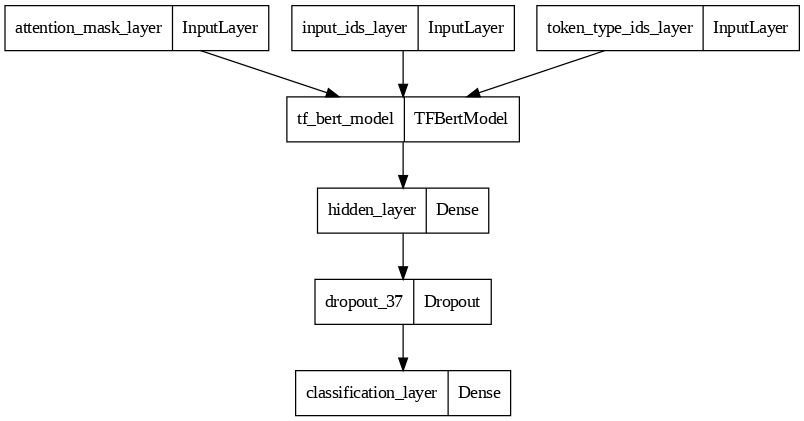

In [ ]:
#keras.utils.plot_model(bert_multiclass_base_model, show_shapes=False, show_dtype=False, show_layer_names=True, dpi=90)